# Translate Rainfall into CV

Followed Kelly's steps on Slack:

1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.
2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)
3. Those average decad values would correspond to the typical climate in the middle of the record.
4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.

For example:
alpha_decad_1(1940) = average_alpha_decad_1  d_seasonal_alpha/dt * 30 years
(assuming the middle of the observation period is 1970)
d_seasonal_alpha/dt  is the slope of the blue line for seasonal alpha. 

Again, we use the long-term seasonal trends for each parameter to adjust the long-term average values for each decad in order to obtain historical (or future) values of the parameters in each decad.

In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

In [7]:
# For now, copying and pasting these functions here so that I can iterate/test them more easily..

def check_exponential(data):

    """ Defines function that fits daily rainfall amounts to an exponential distribution and returns pdf 
        and r2. The r2 should be above 0.9 to be an exponential.

        Usage:

            check_exponential(data):

                returns r2, pdf

        How it works:
        - Step 1: To fit the distribution, we use functions from python's suite of numerical analysis, scipy.
        The scipy.stats module has a large suite of distribution functions pre-defined, which we can use to 
        develop a fit for our data. The distribution we are interested in is the exponential distribution, 
        which is called expon in the stats module.

        - Step 2-4: Calculate fitted PDF and error with fit in distribution. To test the fit of our distribution, 
        we can compare the empirical histogram to that predicted by our model. We first use our `data` to generate 
        the empirical histogram. In this example, we break the data into `30` bins, and we generate a histrogram 
        of `density` rather than counts. This allows for an easier comparison between our empirical data and the 
        fitted probability distribution function. 
        
        Here are the steps:

        1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
        2. Shift the `x` bin locations generated from the histogram to the center of bins.
        3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
        4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according 
        to the equations in rainfall-variability.ipynb.
    """

    # Step 1. Fit the distribution.
    distribution = st.expon
    params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    y, x = np.histogram(data, bins=30, density=True)

    # Step 2. Shift the x bin locations to the center of bins.
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Step 3. Calculate the values of pdx(x) for all x.
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

    # Step 4. Determine the residual and total sum of the squares.
    ss_error = np.sum(np.power(y - pdf, 2.0))
    ss_yy = np.sum(np.power(y - y.mean(), 2.0))

    r_2 = 1 - ( ss_error / ss_yy )

    if r_2 < 0.9:
        print("WARNING. r2 for {station} is {r_2}".format(
            station=station,
            r_2=r_2))

    return r_2, pdf


def make_climate_parameters(
        station='OL JOGI FARM',
        data_file=module_path + '/data/CETRAD/CETRAD_rainfall.csv',
        year_min=30,
        interval='dekad'):

    """ Defines function that takes a rainfall station time series and returns alpha and lambda values by 
    a certain interval between week (7-days), dekad (10-days), semi-monthly (twice per month) or monthly.

        Usage:

            make_climate_parameters(
                station='OL JOGI FARM', 
                data_file="data/CETRAD/CETRAD_rainfall.csv",
                year_min= 30,
                interval='dekad' 
            )

        Default values:
            station = 'OL JOGI FARM' [string] # Rainfall Climatology for Laikipia 
            data_file = "data/CETRAD/CETRAD_rainfall.csv" # Path to file
            year_min = 30 # Minimum number of years required in timeseries
            interval = 'dekad' # Interval to calculate alphas andlambdas

                returns alpha_values, lambda_values
    """
    # Prepare the CETRAD dataset.
    year_min = year_min # minimum number of years to consider for a valid climate record.

    df = pd.read_csv(data_file)  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]
    df['Week'] = [dt.week for dt in df['Datetime']]
    df['Semi_Month'] = (df['Datetime'].dt.day
                          .gt((df['Datetime']+pd.tseries.offsets.MonthEnd()).dt.day//2) 
                          + df['Month']*2 -1)
    df['Dekad'] = df['Datetime'].dt.dayofyear//10+1
    
    n_years = len(df['Year'].unique())

    # Check to make sure we have enough data for fitting and parameter estimation.
    if n_years < year_min:
        print("WARNING! Station record for {station} has only {n_years} years.".format(
            station=station,
            n_years=n_years))

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Semi_Month','Datetime']
    rainfall = df[columns]

    # First, find all the rows in the data where it rained and group by month.
    rain_days = rainfall.loc[rainfall[station] > 0]

    # Find all locations in the data where an observation was made.
    all_days = rainfall.loc[rainfall[station] >= 0]

    # Find just the rainfall amounts on days that it rained.
    data = rainfall.loc[rainfall[station] > 0][station]
    
    # Fit the daily rainfall amounts to an exponential distribution.
    check_exponential(data)

    if interval == 'month':
        # Determine the Monthly values of alpha and lambda from the station data:
        lambda_values = (
            rain_days.groupby('Month')[station].count() /
            all_days.groupby('Month')[station].count()
        )
        alpha_values = rain_days.groupby('Month')[station].mean() # Not mean but sum divided by number of years
    elif interval == 'dekad':
        lambda_values = (
            rain_days.groupby('Dekad')[station].count() / 
            all_days.groupby('Dekad')[station].count()
        )
        alpha_values = rain_days.groupby('Dekad')[station].mean()
    elif interval == 'semi_month':
        lambda_values = (
            rain_days.groupby('Semi_Month')[station].count() / 
            all_days.groupby('Semi_Month')[station].count()
        )
    else:
        raise(NotImplementedError)

    return alpha_values.to_list(), lambda_values.to_list(), rainfall

## Understanding alphas and lambas better

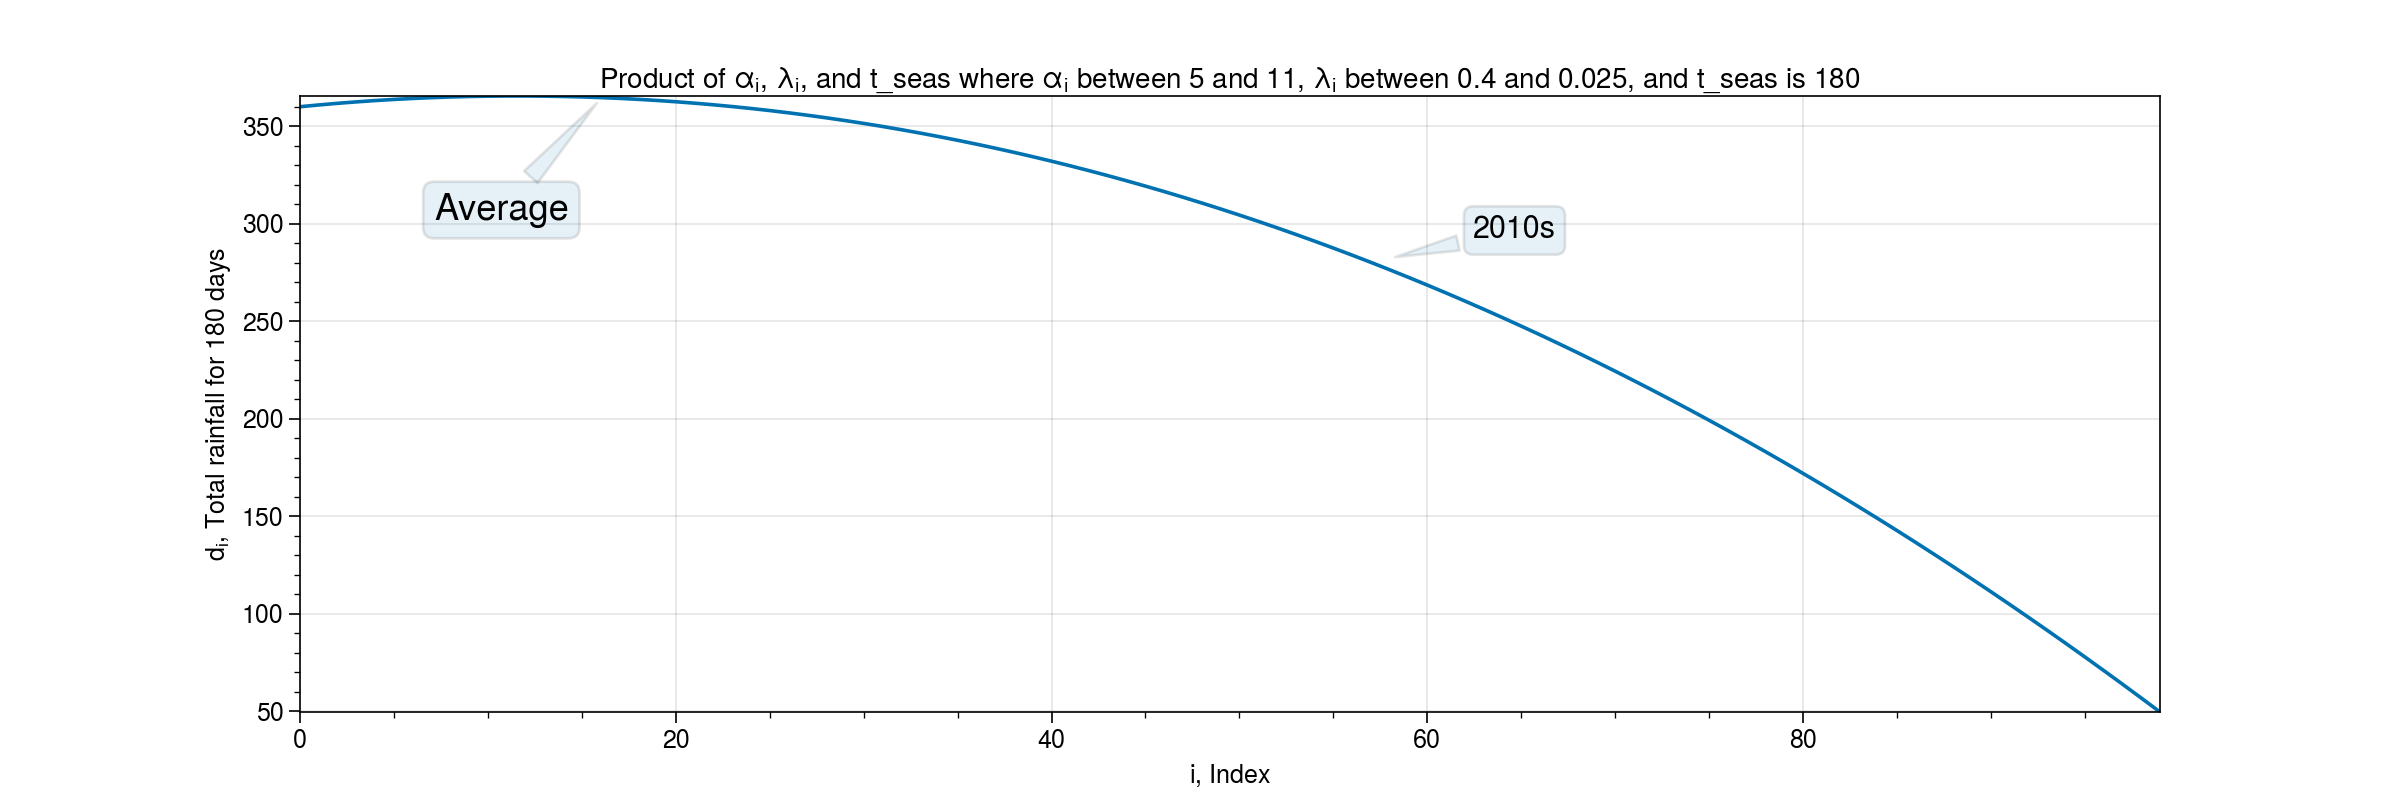

In [8]:
alphas = np.linspace(5,11,100)
lambdas = np.linspace(0.4,.025,100)
t_seas = 180

rainfall = pd.DataFrame(alphas*lambdas*t_seas)

fig, ax = plt.subplots(figsize=(12, 4))

rainfall.plot(ax=ax, label='Total rainfall (mm)')
plt.ylabel('$d_i$, Total rainfall for 180 days')
plt.xlabel('$i$, Index')
plt.title(r'Product of $\alpha_i$, $\lambda_i$, and t_seas where $\alpha_i$ between 5 and 11, $\lambda_i$ between 0.4 and 0.025, and t_seas is 180')

# Can plot where on this curve different seasons fall. 
# Based on three eras:

# Early: 1930s = 180*5.318634*0.359992
# Middle: 1970s (Avg) = 180*7.965385*0.253879
# Late: 2010s = 180*10.612137*0.147766

e = 180*5.318634*0.359992
m = 180*7.965385*0.253879
l = 180*10.612137*0.147766
style = dict(size=10, color='gray')

#ax.legend(rainfall, 'Total rainfall (mm)')
ax.get_legend().remove()

# Having way too much fun with arrows: 
# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
ax.annotate('Average', xy=(16, m),  xycoords='data',
             xytext=(-60, -40), textcoords='offset points',
             size=13, ha='left', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1));

ax.annotate('2010s', xy=(58, l),  xycoords='data',
             xytext=(30, 10), textcoords='offset points',
             size=11, ha='left', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1));


## Things I've tried:
- Do alphas and lambdas from make_climate_parameters make sense: Yes, tested this at bottom of notebook. 
- What does the dekadal rainfall look like? Looks okay: See figure below.
- Do these patterns hold up for another station? **

0    749.945384
dtype: float64

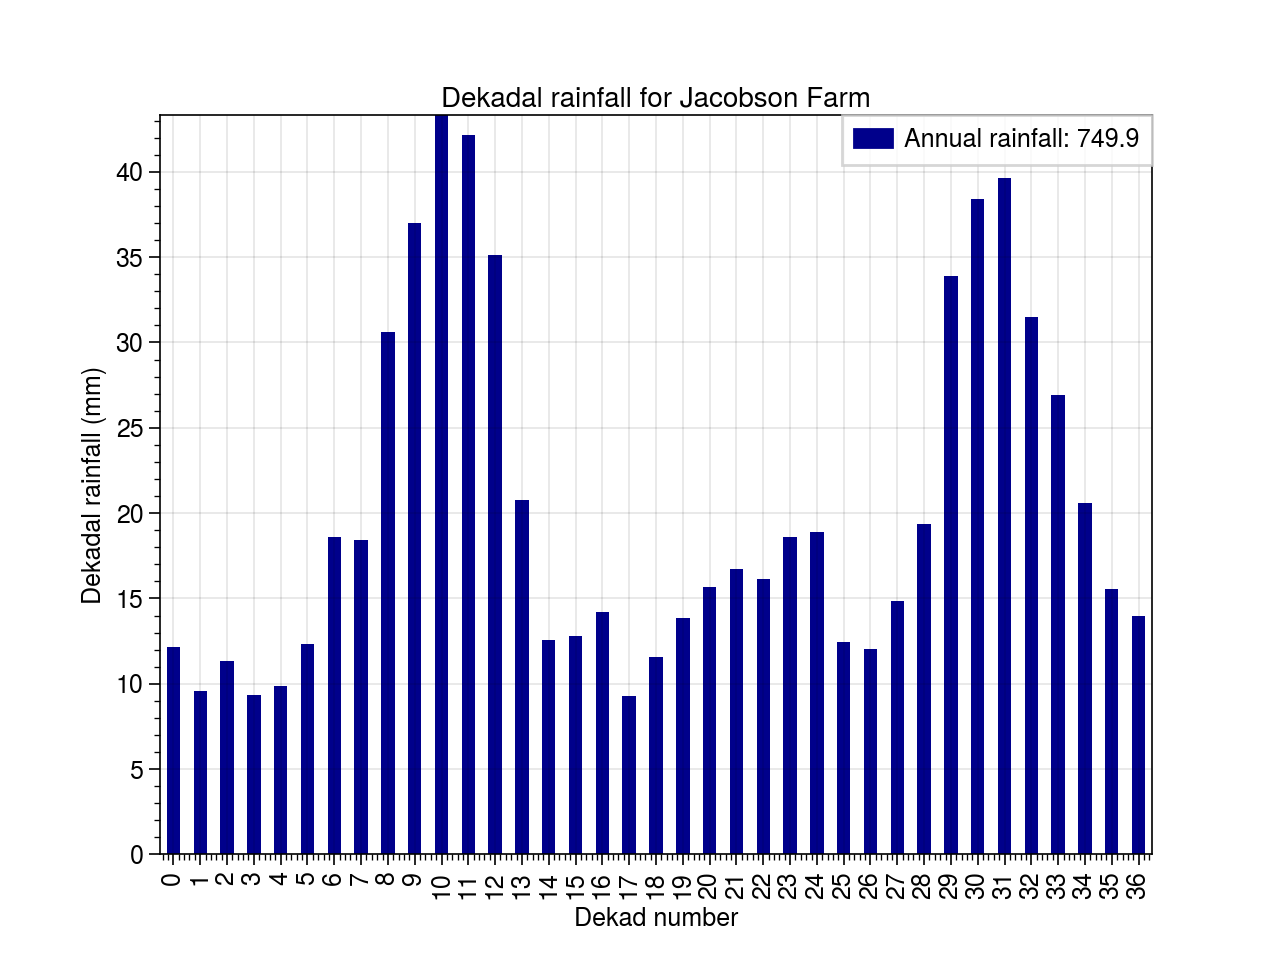

In [9]:
# Actual alphas and lambdas from make_climate_parameters
# What if I get pairs of alphas and lambdas from certain seasons

# This is for Jacobson Farm, may want to do for Ol Jogi
station = 'JACOBSON FARM' # OL JOGI FARM
data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv'
interval='dekad'

a, l, rf = make_climate_parameters(station=station,
                               interval=interval) 

products = [a * b for a, b in zip(a, l)]
# rather than t_seas we're going to break up into 10 day increments
rainfall = [i * 10 for i in products]

rainfall = pd.DataFrame(rainfall)
rainfall.plot(kind='bar', color='darkblue')
plt.xlabel('Dekad number')
plt.ylabel('Dekadal rainfall (mm)')
trf = rainfall.sum() # This seems right
plt.title('Dekadal rainfall for Jacobson Farm')

patch = mpatches.Patch(color='darkblue', label='Annual rainfall: %1.1f'%trf)
plt.legend(handles=[patch])

# And then what's the sum?
trf

In [10]:
# # New a,l don't run
# year_min = 30 # minimum number of years to consider for a valid climate record.

# df = pd.read_csv(data_file)  # Read in the raw csv data.

# # Step 1. Convert text strings into datetime objects.
# format = '%m/%d/%y' # Column RDate has data in M/D/YY
# df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
# df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
# df['Year'] = [dt.year for dt in df['Datetime']]
# df['Month'] = [dt.month for dt in df['Datetime']]
# df['Week'] = [dt.week for dt in df['Datetime']]
# df['Semi_Month'] = (df['Datetime'].dt.day
#                       .gt((df['Datetime']+pd.tseries.offsets.MonthEnd()).dt.day//2) 
#                       + df['Month']*2 -1)
# df['Dekad'] = df['Datetime'].dt.dayofyear//10+1

# n_years = len(df['Year'].unique())

# # Check to make sure we have enough data for fitting and parameter estimation.
# if n_years < year_min:
#     print("WARNING! Station record for {station} has only {n_years} years.".format(
#         station=station,
#         n_years=n_years))

# # Step 4. Use the Datetime values as the index for this dataframe.
# df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# # Step 5.  Delete the old RDate column, which we no longer need. 
# # We will keep the Datetime column, in case we need it later.
# df = df.drop(['RDate'], axis=1)

# columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Semi_Month','Datetime']
# rainfall = df[columns]

# # First, find all the rows in the data where it rained and group by month.
# rain_days = rainfall.loc[rainfall[station] > 0]

# # Find all locations in the data where an observation was made.
# all_days = rainfall.loc[rainfall[station] >= 0]

# # Find just the rainfall amounts on days that it rained.
# data = rainfall.loc[rainfall[station] > 0][station]

# # Fit the daily rainfall amounts to an exponential distribution.
# check_exponential(data)

# if interval == 'month':
#     # Determine the Monthly values of alpha and lambda from the station data:
#     lambda_values = (
#         rain_days.groupby('Month')[station].count() /
#         all_days.groupby('Month')[station].count()
#     )
#     alpha_values = rain_days.groupby('Month')[station].mean()
# elif interval == 'dekad':
#     lambda_values = (
#         rain_days.groupby('Dekad')[station].count() / 
#         all_days.groupby('Dekad')[station].count()
#     )
#     alpha_values = rain_days.groupby('Dekad')[station].sum()/80 # New way of calculating.. not divided by 10
# elif interval == 'semi_month':
#     lambda_values = (
#         rain_days.groupby('Semi_Month')[station].count() / 
#         all_days.groupby('Semi_Month')[station].count()
#     )
# else:
#     raise(NotImplementedError)


# #alpha_values # This does seem like it way over estimates the size of the storm

# a=alpha_values.to_list() 
# l=lambda_values.to_list()
# r=rainfall

In [12]:
#rain_days.groupby('Dekad')[station].sum()/80 # This still seems like an over estimate
#rain_days.groupby('Month')[station].mean()
#rain_days.groupby('Dekad')[station].sum()/80/10

## New way of calculating historical alphas and lambdas

#### 1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.

These values are from the trend graphs in `1-rainfall-variability-stats`.

In [13]:
# Make a plot of the slopes for Jacobson Farm for alpha and lambda
t = pd.Series([1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
            1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
            1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
            1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
            1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
            1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
            2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014])
m_al=0.06616878857577158
m_ll=-0.002652831781941007
c_al=-121.90153294377794
c_ll=5.578343185001898

In [14]:
def lin_reg(x_dat=None, m=None, c=None):
    """Doc strings here
    
    """
    y_dat = m*x_dat + c
    
# Below is old code
#     if stress > 1:
#         raise ValueError("static stress, {stress} is larger than 1".format(
#                 stress=stress))
#     if stress < 0:
#         raise ValueError("static stress, {stress} is less than 0".format(
#                 stress=stress))
    
    return y_dat

# this is the list of alphas
lin_reg(x_dat=t, m=m_al, c=c_al)

0      6.068904
1      6.135073
2      6.201242
3      6.267411
4      6.333579
        ...    
76    11.097732
77    11.163901
78    11.230070
79    11.296238
80    11.362407
Length: 81, dtype: float64

#### 2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)

Seasonally varying component = alpha and lambdas as I've made them before. 


In [15]:
# This is for Jacobson Farm, may want to do for Ol Jogi
station = 'JACOBSON FARM' # OL JOGI FARM
data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv'
interval='dekad'

a, l, rf = make_climate_parameters(station=station,
                               interval=interval) 
# make a dataframe
df_mid = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})
df = df_mid

#### 3. Those average decad values would correspond to the typical climate in the middle of the record.

Use those values as the typical climate in the middle of the record.

In [16]:
# So this dataframe 'df' corresponds to the alpha and lambdas we want to use for the middle points on the plot

# Run the model with these values. Do this here or elsewhere. Pending.

In [17]:
def run(n_sim = 1000, burn_in = 60, texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad',
       alpha_r=None, lambda_r=None):
    """ Set up model conditions for model runs. 

    Usage: run(n_sim, burn_in, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = TODO

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = abs(burn_in - pd_sim) # absolute value

    # Part 2. Initialize model with a climate, soil and crop
    s0_climate = Climate(alpha_r=alpha_r, lambda_r=lambda_r)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=doy)
    models = [CropModel(
                  crop=crop,
                  climate=Climate(alpha_r=s0_climate.alpha_r, lambda_r=s0_climate.lambda_r),
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations
    planting_date = pd_sim 
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg soil moisture
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    #print('done')
    
    # Part 6. Output the dynamic stress and yield values (just added this 08-17-2020)
    # old: x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress) for df in output] #for i in np.arange(n_sim)
    i=lgp
    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in output] # I have no clue whether this will work
    
    #print(output[0][start:end].s)
    rf = [df[start:end]['R'].sum() for df in output]
    mam_rf = [df[start:start+92]['R'].sum() for df in output] # This goes from day 60 to day 51: March 1 to May 31
    
    return x, rf, int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in, mam_rf

x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in, mam_rf = run(alpha_r=a, lambda_r=l)



In [18]:
# Define variables
soil = Soil(texture=texture)
crop = Crop(soil=soil, lgp=lgp)
soil.set_nZr(crop)

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=d.s, stress=d.stress) for d in output] 
RF = [d['R'].sum() for d in output]
result = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
result['RF'] = RF
result['mam_RF'] = mam_rf

# Save this time series as the middle time series

# Cat them all together
#pd.DataFrame()
result['Cat'] = 'mid'
result

,AvgStress,DynamicStress,Yield,RF,mam_RF,Cat
0,0.422691,0.507403,2098.463305,454.886683,214.752433,mid
1,0.502462,0.572637,1820.566471,411.773440,230.305916,mid
2,0.438220,0.609558,1663.281332,396.421909,213.810865,mid
3,0.425458,0.724817,1172.279835,460.898457,214.014571,mid
4,0.398126,0.354163,2751.266631,604.764240,389.951177,mid
...,...,...,...,...,...,...
995,0.313275,0.572264,1822.154288,465.292939,257.844432,mid
996,0.248506,0.289064,3028.587113,572.047996,363.811439,mid
997,0.329303,0.488694,2178.164006,476.276582,247.051516,mid
998,0.425641,1.000000,0.000000,378.077845,198.780780,mid


In [19]:
df = df_mid

#### 4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.



In [20]:
# If there are 80 years in the record from 1934-2014, then half way is 1974
alphas_2010 = df['alpha']+m_al*40; alphas_2010
alphas_1930 = df['alpha']-m_al*40; alphas_1930 #-df['alpha']*2

# # I'm not sure if math makes sense but they're around the numbers I want
lambdas_2010 = df['lambda']+m_ll*40; lambdas_2010 
lambdas_1930 = df['lambda']-m_ll*40; #lambdas_1930 #+df['lambda']*2; alphas_1930


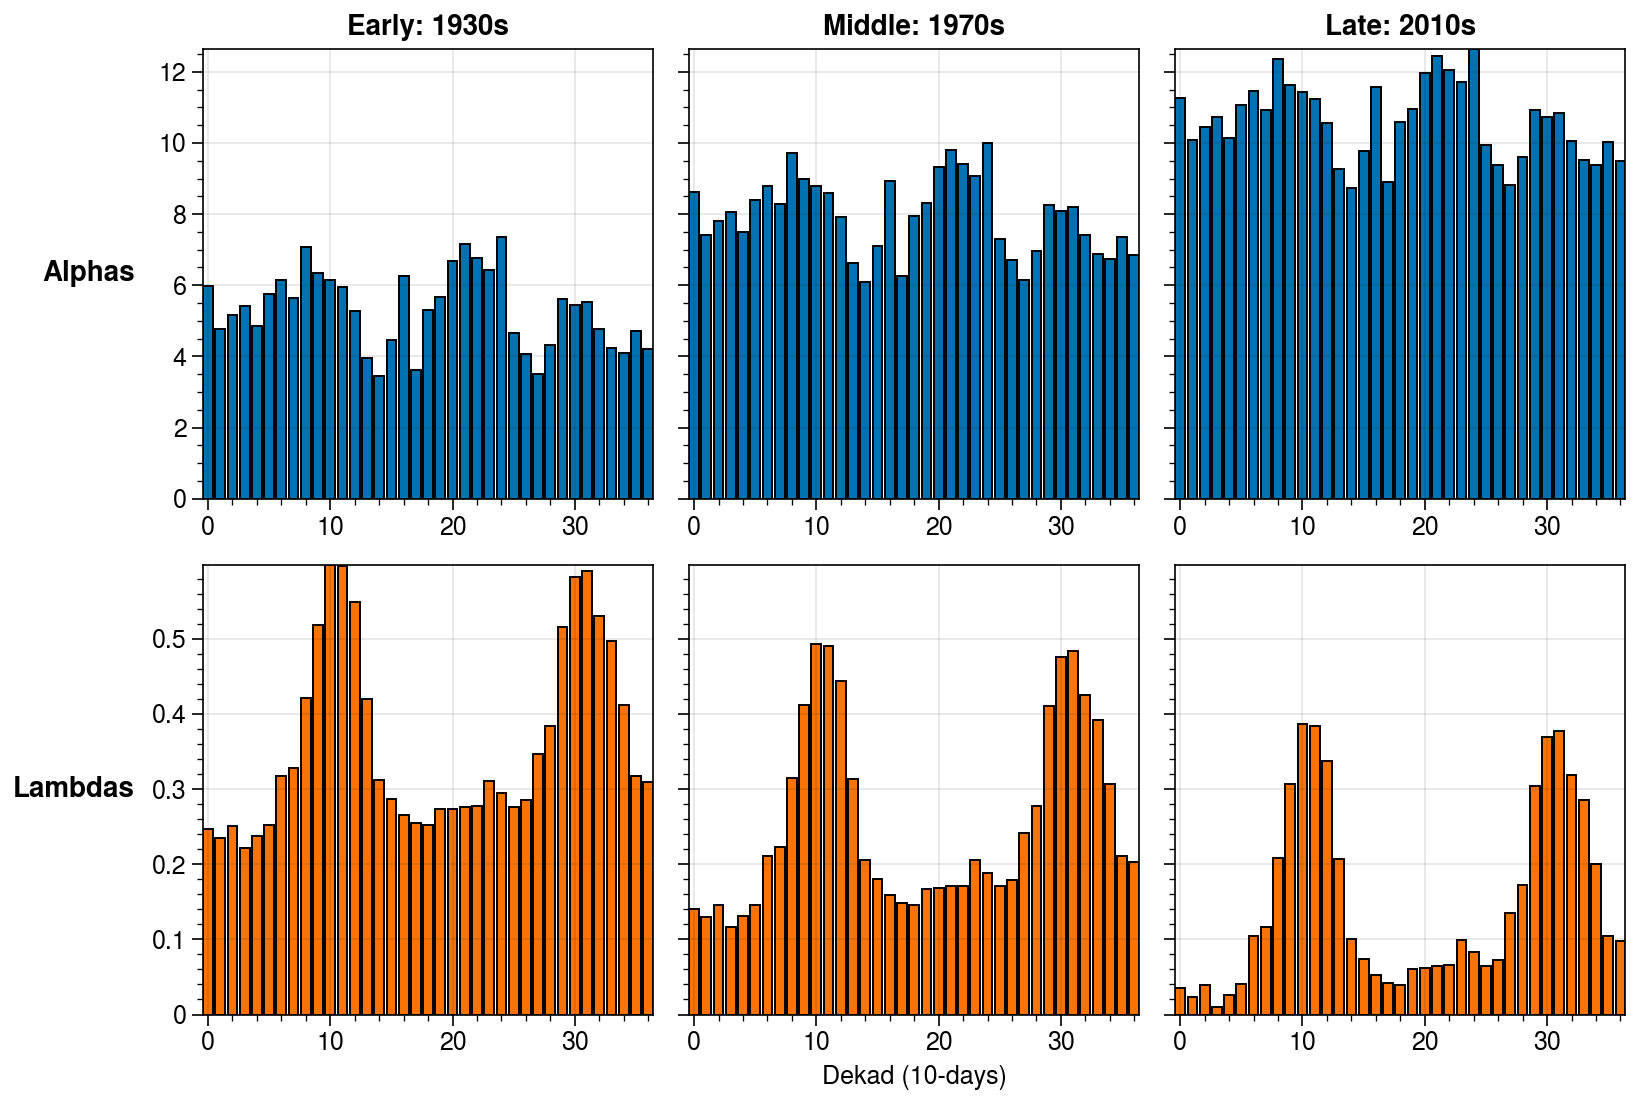

In [21]:
# Make three bar subplots of the deakadal alphas and lambdas
f, ax = plot.subplots(nrows=2, ncols=3, sharex=True) # , sharey=1

ax.format(
    rowlabels=['Alphas', 'Lambdas'],
    collabels=['Early: 1930s', 'Middle: 1970s', 'Late: 2010s']
)

ax[0,0].bar(alphas_1930)
ax[0,1].bar(df_mid.alpha)
ax[0,2].bar(alphas_2010)

ax[1,0].bar(lambdas_1930, color='orange')
ax[1,1].bar(df_mid['lambda'], color='orange')
ax[1,2].bar(lambdas_2010, color='orange')

# Good ol labels
#ax[0:].format(ylabel='Avg. depth per storm (mm)')
#ax[1:].format(ylabel='Inter-storm arrival rate (day^-1)')
ax[:3:2].format(xlabel='Dekad (10-days)')
ax[1:].format(ylabel='')

In [54]:
# Export alphas and lambdas for testing
pd.DataFrame({ 'alpha': alphas_1930, 'lambda': lambdas_1930, 'dekad':np.arange(1,38) }).to_csv('../output/3-cv-translation/dekads_1930s.csv',sep=',')
pd.DataFrame({ 'alpha': alphas_2010, 'lambda': lambdas_2010, 'dekad':np.arange(1,38) }).to_csv('../output/3-cv-translation/dekads_2010s.csv',sep=',')

df.drop(['doy'],axis=1, inplace=True)

pd.DataFrame({ 'alpha': df['alpha'], 'lambda': df['lambda'], 'dekad':np.arange(1,38) }).to_csv('../output/3-cv-translation/dekads_avg.csv',sep=',')

In [227]:
# Run the sims for 2010
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in, mam_rf = run(
       burn_in = 60, texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad',
       alpha_r=alphas_2010, lambda_r=lambdas_2010)

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=d.s, stress=d.stress) for d in output] 
RF = [d['R'].sum() for d in output]

result_2010 = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
result_2010['RF'] = RF
result_2010['mam_RF'] = mam_rf
#print(max(df.Yield)/1000)
result_2010['Cat'] = 'late'


In [228]:
# Run the sims for 1940
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in, mam_rf = run( 
       burn_in = 60, texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad',
       alpha_r=alphas_1930, lambda_r=lambdas_1930)

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=d.s, stress=d.stress) for d in output] 
RF = [d['R'].sum() for d in output]

result_1930 = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
result_1930['RF'] = RF
result_1930['mam_RF'] = mam_rf
#print(max(df.Yield)/1000)
result_1930['Cat'] = 'early'


In [229]:
# Cat the three dataframes together
result_list = [result_1930, result, result_2010]
pd.concat(result_list)

r0=result_1930
r1=result
r2=result_2010

In [245]:
alphas_2010
from statistics import mean 

mean(a)
mean(alphas_1930)

#np.var(r0.RF)
np.std(a)

1.0495153107976176

In [246]:
# Do table and plot

# Let's add average rainfall

df = pd.DataFrame({'Rainfall Climatology':['Early: 1930s','Middle: 1970s (Avg)','Late: 2010s'],
                   # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
            'Maize Variety':[180,180,180],
            'Average Alpha (mm)':[mean(alphas_1930), mean(a), mean(alphas_2010)],
            'Average Lambda (day^-1)':[mean(lambdas_1930), mean(l), mean(lambdas_2010)],
            'Average Rainfall (mm)':[r0.RF.mean(), r1.RF.mean(), r2.RF.mean()],
            #'Variance Rainfall':[np.var(r0.RF),np.var(r1.RF),np.var(r2.RF)],
            'SD Rainfall':[np.std(r0.RF),np.std(r1.RF),np.std(r2.RF)],
            'CV Rainfall (mm)':[r0.RF.std()/r0.RF.mean(), 
                                r1.RF.std()/r1.RF.mean(),
                                r2.RF.std()/r2.RF.mean()],
            'Average Yield (t/ha)': [np.nanmean(r0.Yield/1000), np.nanmean(r1.Yield/1000), np.nanmean(r2.Yield/1000)],
            'Probability of Crop Failure (%)':[len(r0.loc[r0['Yield'] == 0].count(axis=1))/len(r0)*100,
                                               len(r1.loc[r1['Yield'] == 0].count(axis=1))/len(r1)*100,
                                               len(r2.loc[r2['Yield'] == 0].count(axis=1))/len(r2)*100]})
df

,Rainfall Climatology,Maize Variety,Average Alpha (mm),Average Lambda (day^-1),Average Rainfall (mm),SD Rainfall,CV Rainfall (mm),Average Yield (t/ha),Probability of Crop Failure (%)
0,Early: 1930s,180,5.318634,0.359992,465.551207,67.034637,0.144062,1.516342,21.5
1,Middle: 1970s (Avg),180,7.965385,0.253879,466.247811,79.997105,0.171662,1.879234,10.6
2,Late: 2010s,180,10.612137,0.147766,323.956122,80.365300,0.248199,1.077550,27.1


[Text(0, 0, ''),
 Text(0, 0, 'Early (1930s)'),
 Text(0, 0, ''),
 Text(0, 0, 'Middle (Avg.)'),
 Text(0, 0, ''),
 Text(0, 0, 'Late (2010s)')]

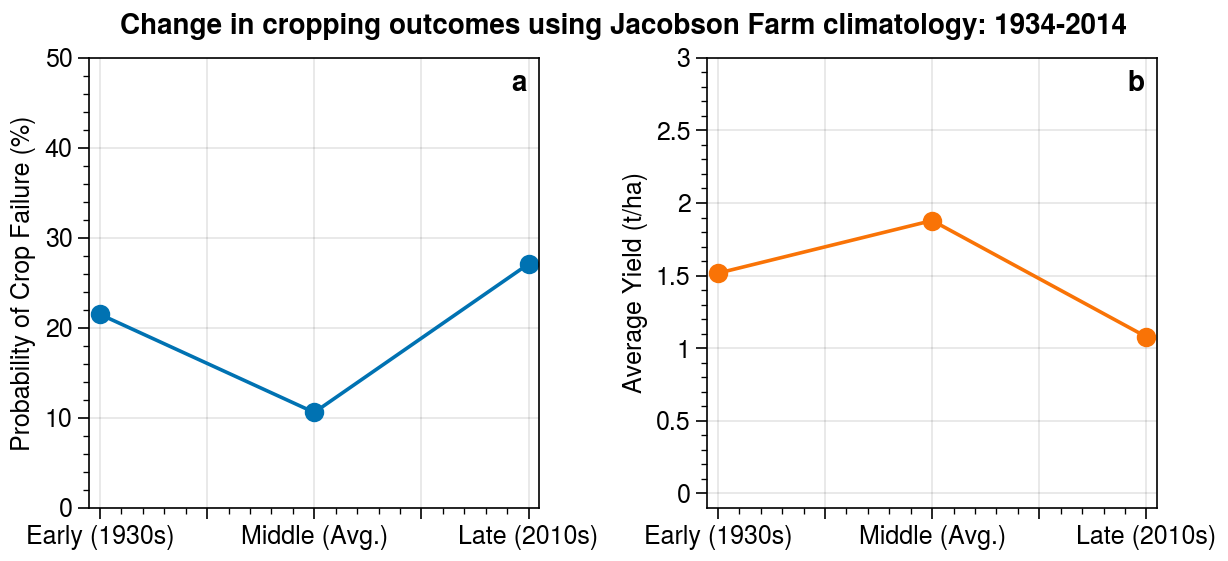

In [232]:
# Make final figure for manuscript

f, ax = plot.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
ax.format(
         suptitle='Change in cropping outcomes using Jacobson Farm climatology: 1934-2014',
         #title='reference', titleweight='bold',
         #titleloc='uc', titlecolor='red9'
        abc=True, abcloc='ur' # xlabel='Year', 
     )

#ax.format(suptitle='')
# Consider adding some kind of error bar: yerr=df['Probability of Crop Failure (%)']
df['Probability of Crop Failure (%)'].plot(marker='o',markersize=6, ax=ax[0])
ax[0].set(ylim=(0,50))
#ax[0].set(ylabel='Probability of Crop Failure (%)')
ax[0].format(ylabel='Probability of Crop Failure (%)')
ax[0].set(xlim=(-0.05,2.05))
ax[0].set_xticklabels(['','Early (1930s)', '',
                      'Middle (Avg.)','','Late (2010s)'])
#ax[0].set_xticklabels(['','1935-1940', '',
#                      '1972-1977','','2010-2015'])

df['Average Yield (t/ha)'].plot(marker='o',markersize=6, ax=ax[1], color='orange')
ax[1].set(ylim=(-0.1,3))
ax[1].set(xlim=(-0.05,2.05))
#ax[1].set(ylabel='Average Yield (t/ha)')
ax[1].format(ylabel='Average Yield (t/ha)')


ax[1].set_xticklabels(['','Early (1930s)', '',
                      'Middle (Avg.)','','Late (2010s)'])

#plt.savefig('../output/2-rainfall-variability/final.png')

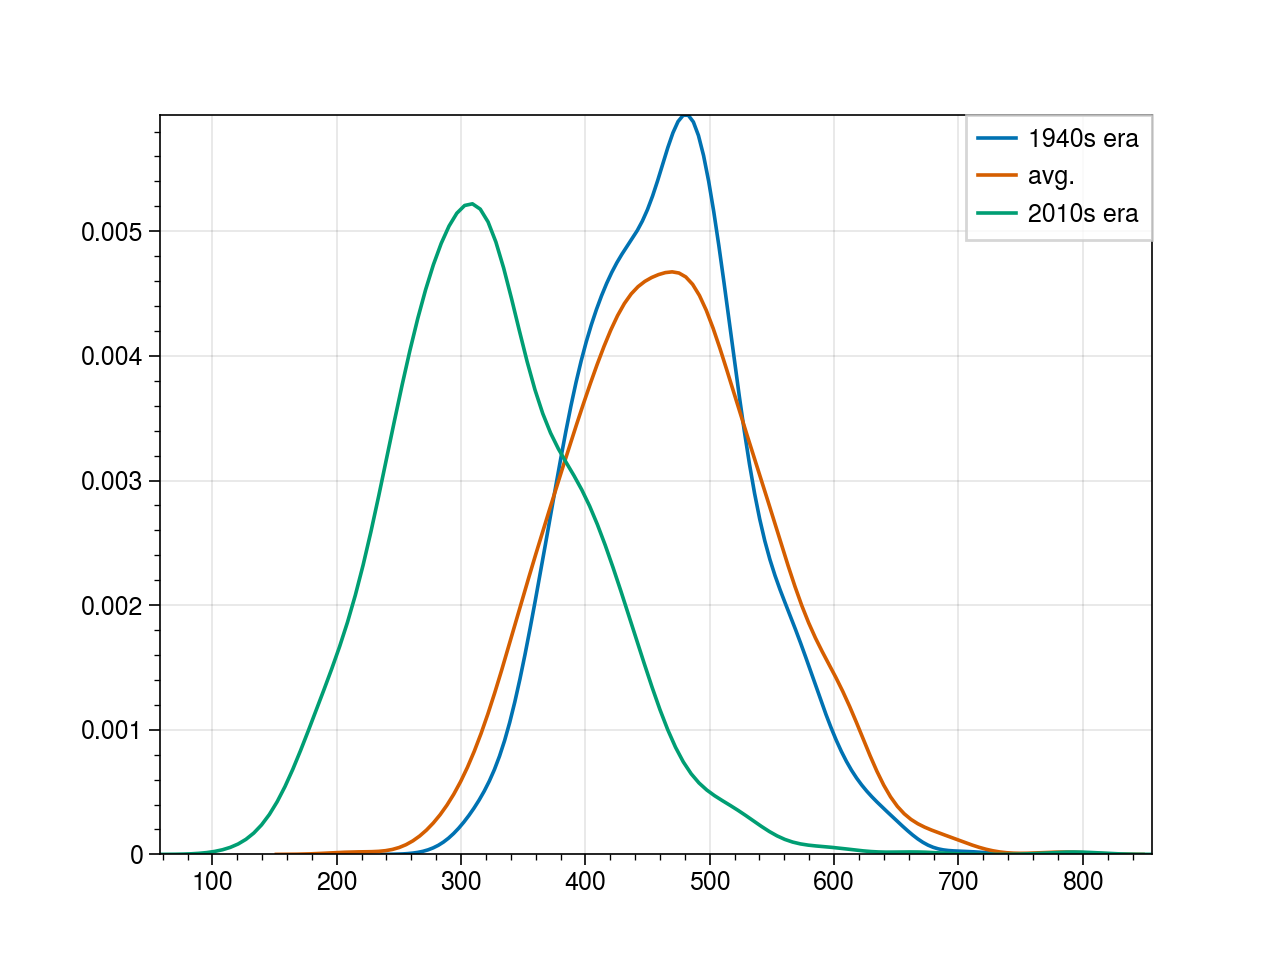

In [233]:
# Maybe do boxplot to better vis variance in rainfall

#r0['RF'].plot(kind='box')
#r0['RF'].plot(kind='hist')

#sns.distplot(r0['RF'])
# sns.distplot(r0['RF'], color = 'r', kde = False)
# sns.distplot(r1['RF'], color = 'k', kde = False)
# sns.distplot(r2['RF'], color = 'b', kde = False)

sns.kdeplot(r0['RF'], label="1940s era") # can change bandwith to see how tightly estimation fits the data
sns.kdeplot(r1['RF'], label="avg.") # bw=.2
sns.kdeplot(r2['RF'], label="2010s era")
plt.legend();


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'xlim', 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'xlim', 'ylim', 'kind'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


[Text(0.5, 0, '')]

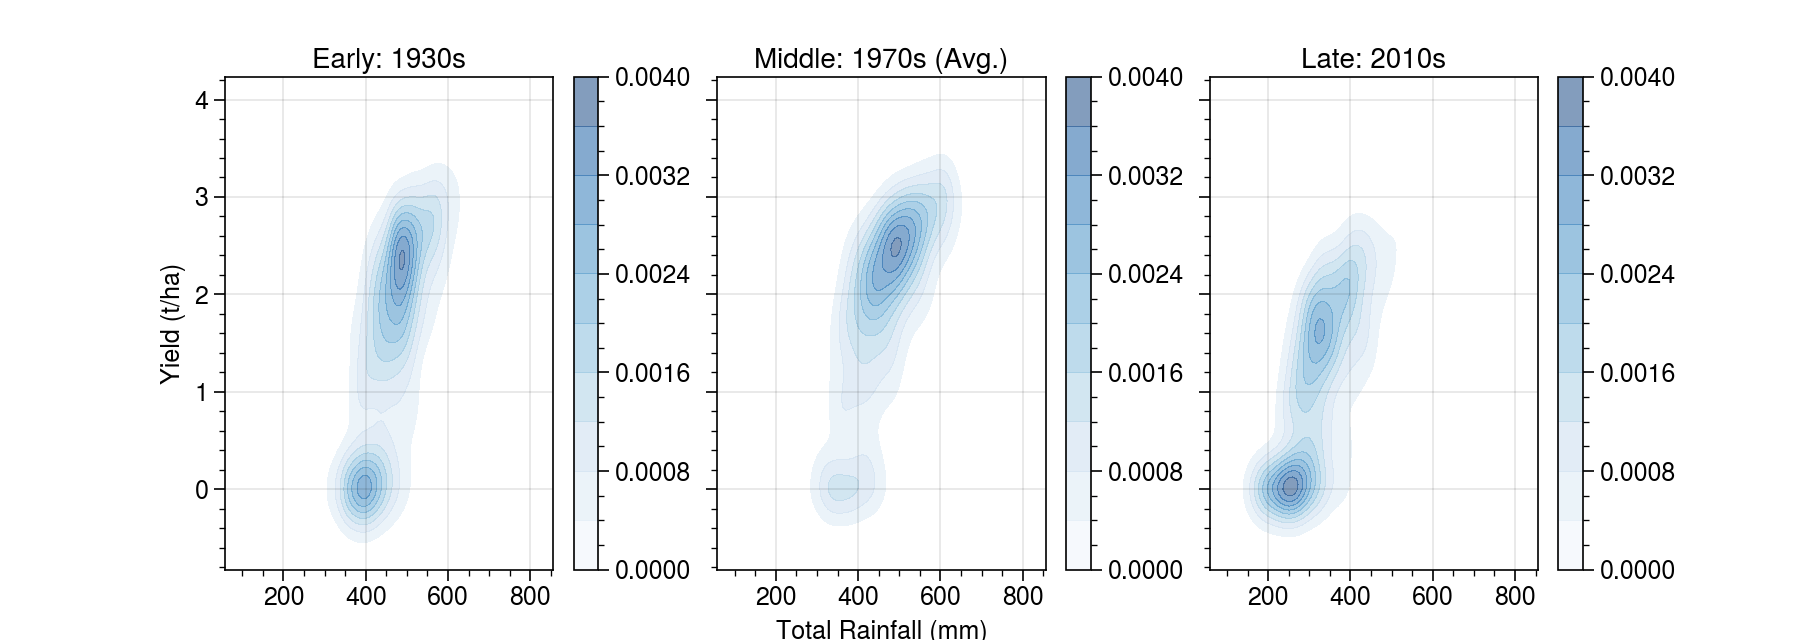

In [234]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3.2), sharey=True, sharex=True)

# ax.format(
#     rowlabels=['Yield (t/ha)'],
#     collabels=['Early: 1930s', 'Middle: Avg', 'Late: 2010s']
# )


sns.kdeplot(r0.RF, r0.Yield/1000, xlim=(0,700),alpha=0.5, kind='kde',cmap="blues", shade=True, 
                shade_lowest=False, cbar=True, ax=ax[0]).set_title('Early: 1930s')


ax[0].set(xlabel='')
ax[0].set(ylabel='Yield (t/ha)')

ax2 = ax[1]
sns.kdeplot(r1.RF, r1.Yield/1000, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="blues", 
                  shade=True, shade_lowest=False, cbar=True,ax=ax2).set_title('Middle: 1970s (Avg.)')
ax2.set(xlabel='Total Rainfall (mm)')
ax2.set(ylabel='')
ax3 = ax[2]
#plt.show()
sns.kdeplot(r2.RF, r2.Yield/1000,xlim=(0,700),ylim=(-0.5,4.5), alpha=0.5,kind='kde',cmap="blues", 
            shade=True, shade_lowest=False, cbar=True, ax=ax3).set_title('Late: 2010s') #greens

ax3.set(ylabel='')
ax3.set(xlabel='')

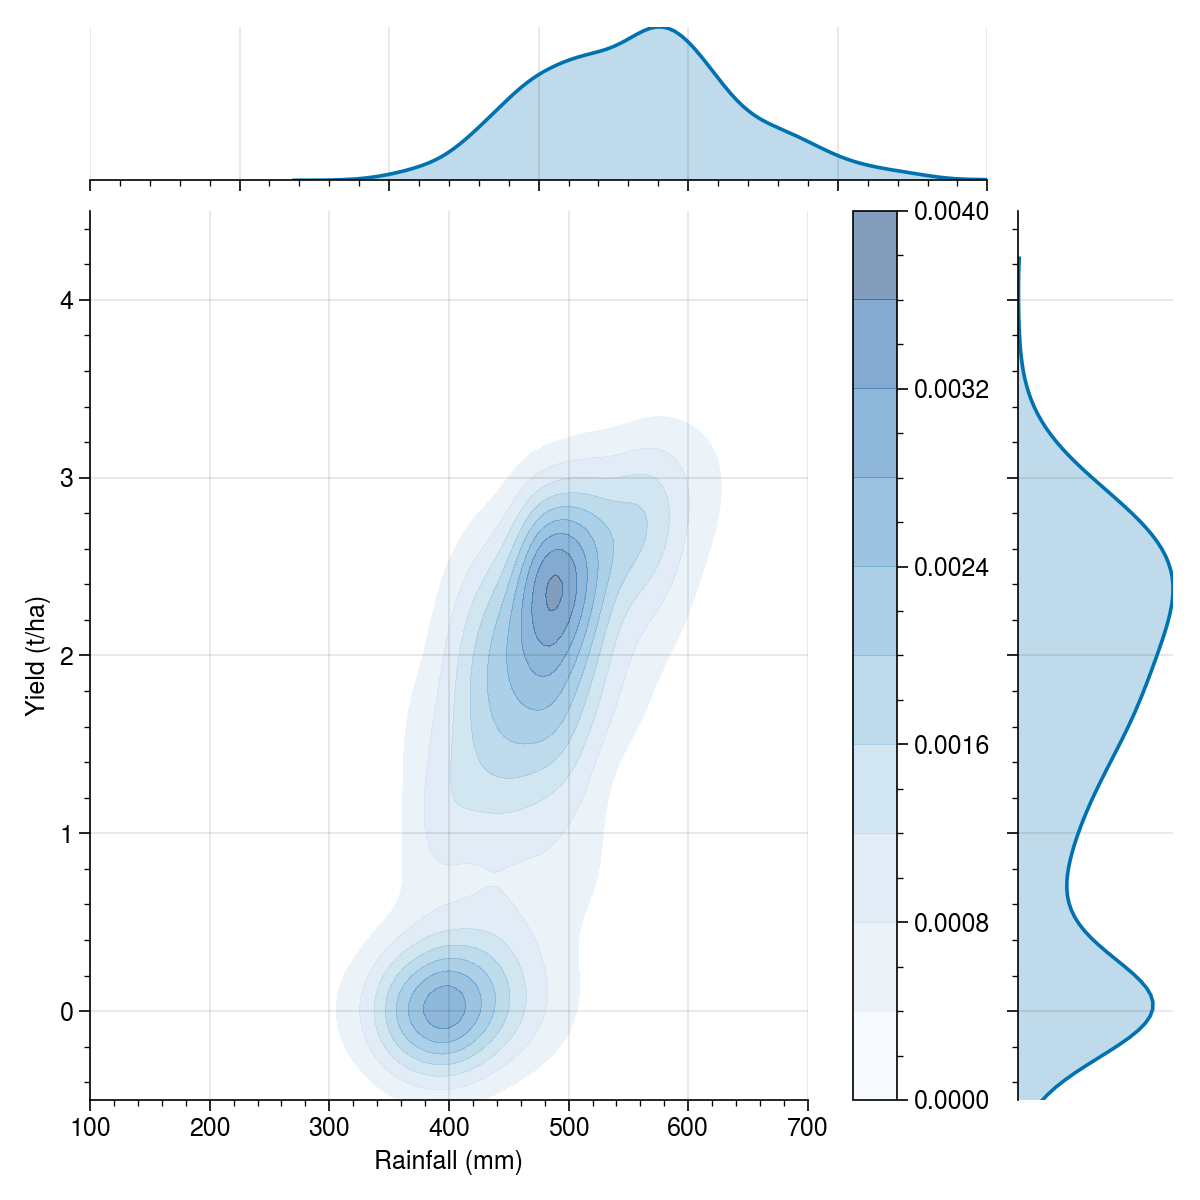

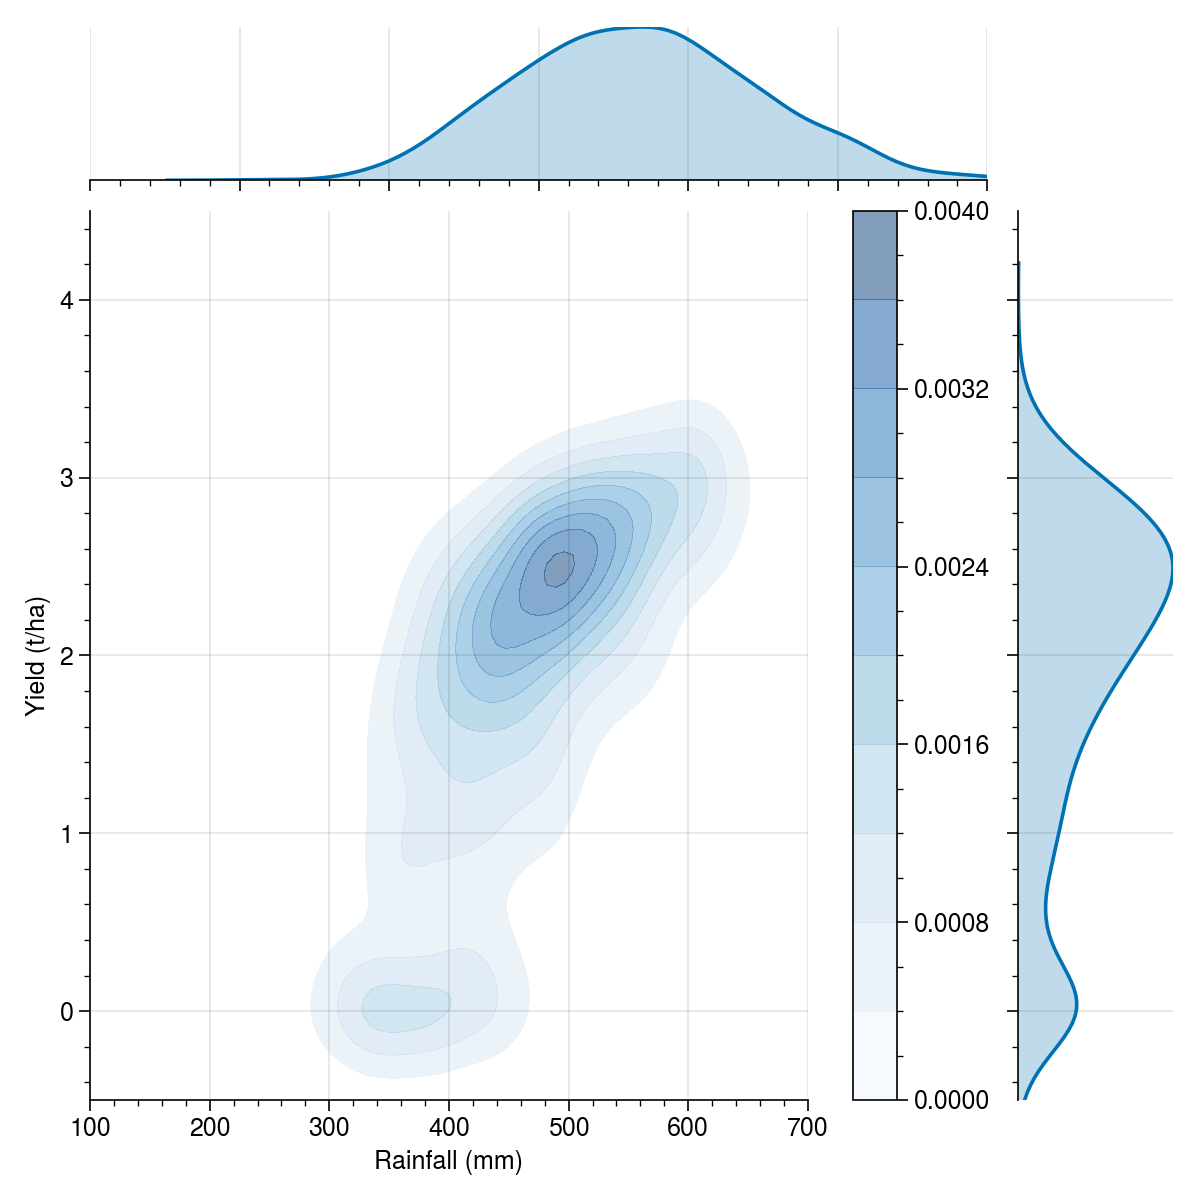

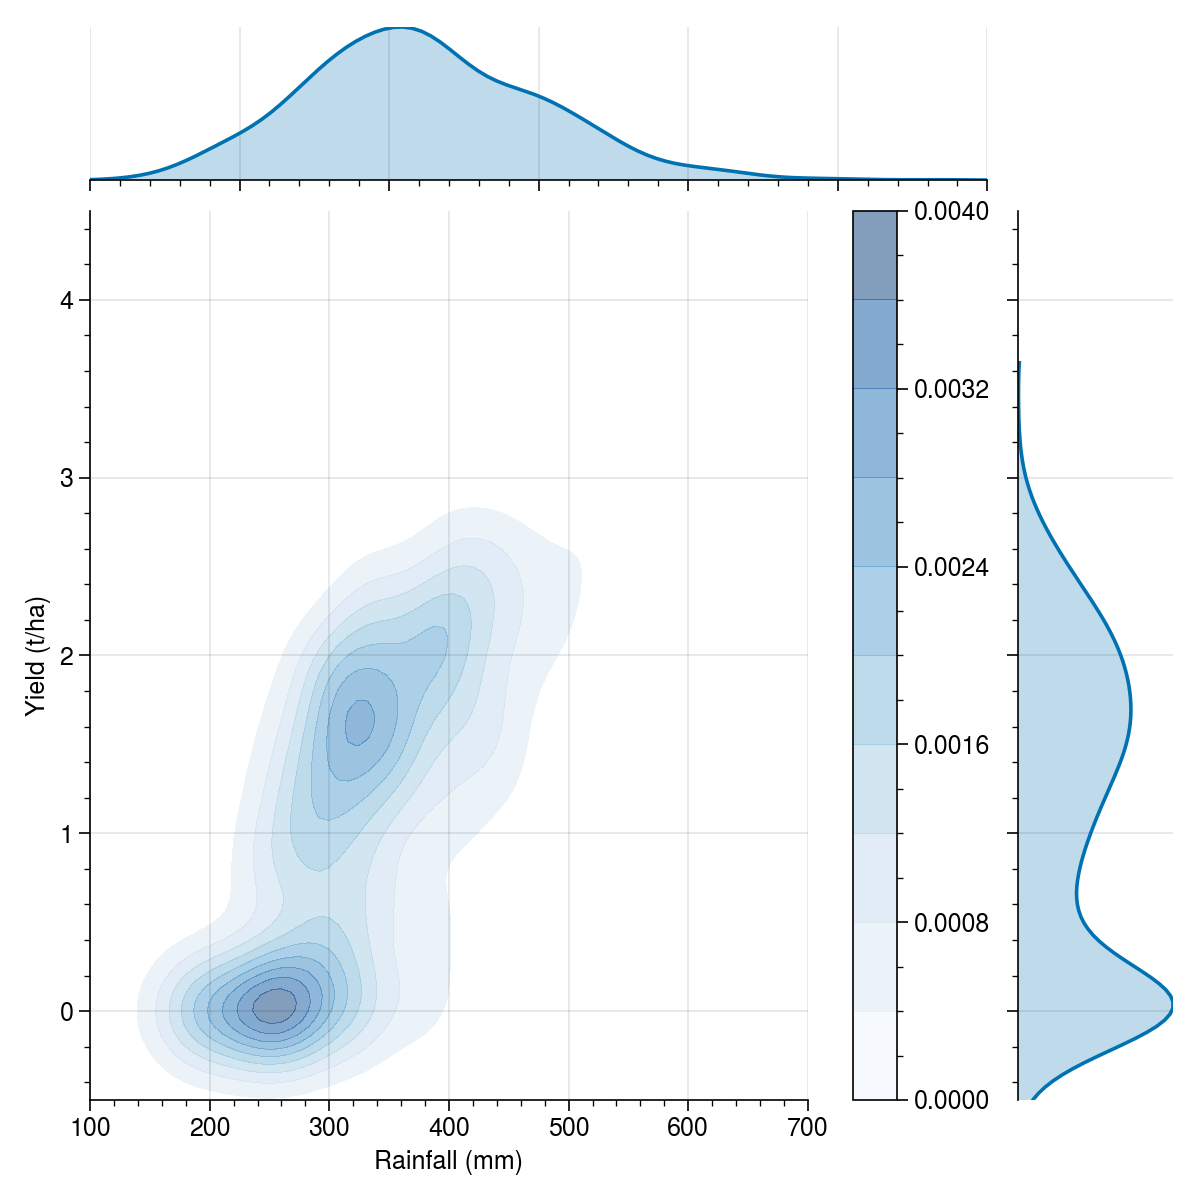

In [235]:
# Add distributions -- It's difficult to get these all on the same figure so I am going to do it manually

# f, ax = plot.subplots(nrows=1, ncols=1)

# ax.format(
#          suptitle='Change in cropping outcomes using Jacobson Farm climatology: 1935-2015',
#          #title='reference', titleweight='bold',
#          #titleloc='uc', titlecolor='red9'
#         abc=True, abcloc='ur' # xlabel='Year', 
#      )
#plt.title('Middle: 1970s (Avg.)')
#fig, ax = plt.subplots()

g = sns.jointplot(r0.RF, r0.Yield/1000, xlim=(100,700),ylim=(-0.5,4.5),alpha=0.5, kind='kde',
              cmap="blues", shade=True, shade_lowest=False, cbar=True)#.set_title()
#plt.text(200,4, "Early Era: 1930s", fontsize = 55, color='Black') # , fontstyle='bold

# Honeslty dont know that I want to mess with this right now
g.set_axis_labels("Rainfall (mm)", "Yield (t/ha)") # , fontsize=16
#ax.annotate(s='Early Era: 1930s',xy=(200,4)) # , loc="upper left", fontsize=12

#plt.xlabel('Rainfall (mm)')
#plt.ylabel('Yield (t/ha)')

g = sns.jointplot(r1.RF, r1.Yield/1000, xlim=(100,700),ylim=(-0.5,4.5),alpha=0.5, kind='kde',
              cmap="blues", shade=True, shade_lowest=False, cbar=True)#.set_title()
#plt.text(200,4, "Early Era: 1930s", fontsize = 55, color='Black') # , fontstyle='bold

# Honeslty dont know that I want to mess with this right now
g.set_axis_labels("Rainfall (mm)", "Yield (t/ha)") # , fontsize=16

g = sns.jointplot(r2.RF, r2.Yield/1000, xlim=(100,700),ylim=(-0.5,4.5),alpha=0.5, kind='kde',
              cmap="blues", shade=True, shade_lowest=False, cbar=True)#.set_title()
#plt.text(200,4, "Early Era: 1930s", fontsize = 55, color='Black') # , fontstyle='bold

# Honeslty dont know that I want to mess with this right now
g.set_axis_labels("Rainfall (mm)", "Yield (t/ha)") # , fontsize=16

In [236]:
# Plot of % failure against rainfall totals
# Could keep thinking about this

## Doing some checks:

Are 3 month rainfall totals are those reasonable for three eras with three month model observations (check)


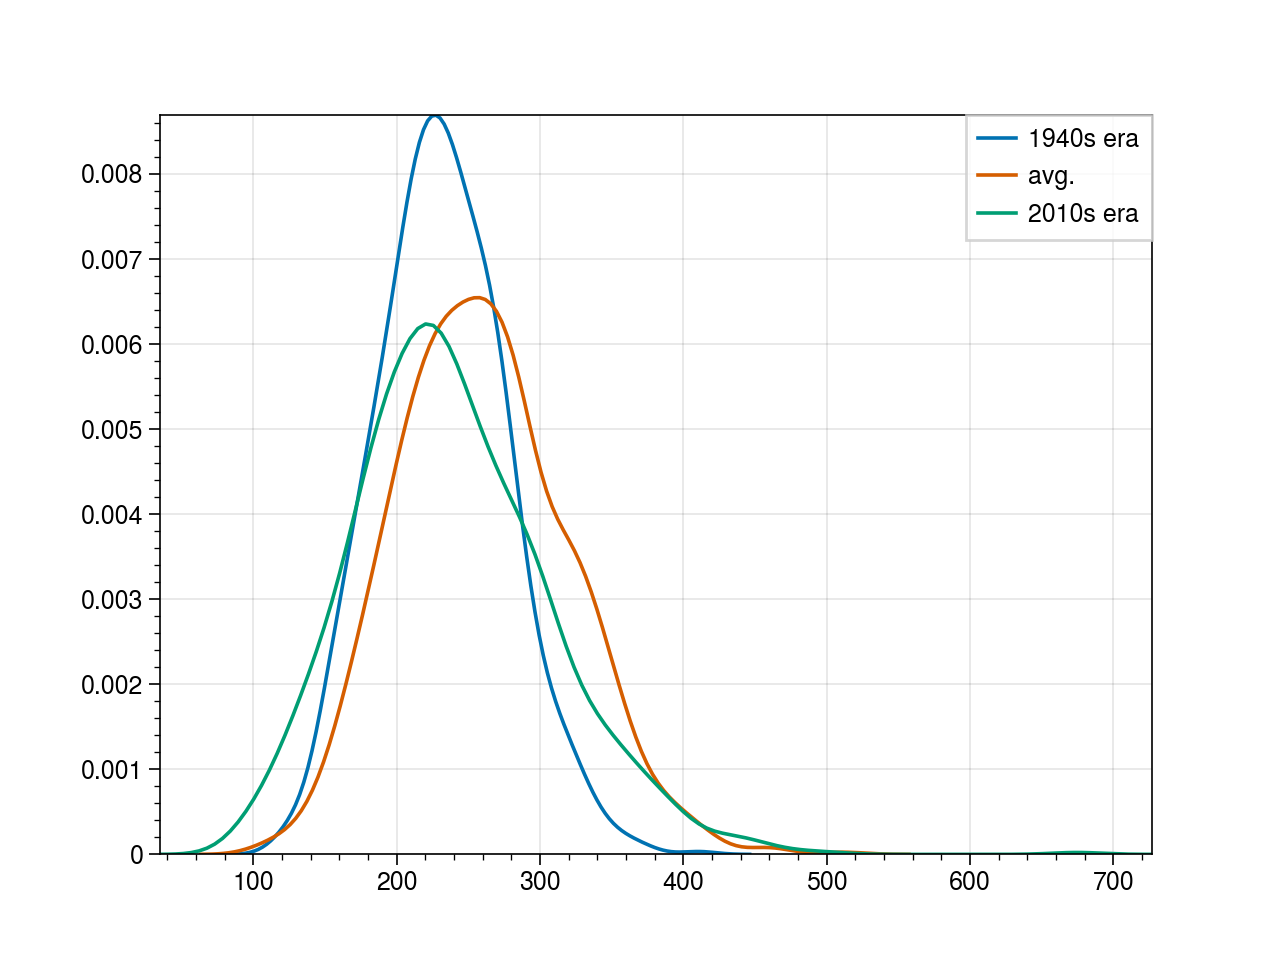

In [237]:
# Distributions of MAM rainfall

sns.kdeplot(r0['mam_RF'], label="1940s era") # can change bandwith to see how tightly estimation fits the data
sns.kdeplot(r1['mam_RF'], label="avg.") # bw=.2
sns.kdeplot(r2['mam_RF'], label="2010s era")
plt.legend();

In [238]:
# Distribution 

a_jf, l_jf, rf_jf = make_climate_parameters(
        station='JACOBSON FARM',
        data_file=module_path + '/data/CETRAD/CETRAD_rainfall.csv',
        year_min=30,
        interval='dekad')

rf = rf_jf.dropna()
rf

,JACOBSON FARM,Year,Month,Week,Dekad,Semi_Month,Datetime
Datetime,,,,,,,
1934-01-01,0.0,1934,1,1,1,1,1934-01-01
1934-01-02,0.0,1934,1,1,1,1,1934-01-02
1934-01-03,0.0,1934,1,1,1,1,1934-01-03
1934-01-04,0.0,1934,1,1,1,1,1934-01-04
1934-01-05,0.0,1934,1,1,1,1,1934-01-05
...,...,...,...,...,...,...,...
2015-02-24,0.0,2015,2,9,6,4,2015-02-24
2015-02-25,0.0,2015,2,9,6,4,2015-02-25
2015-02-26,0.0,2015,2,9,6,4,2015-02-26


,Source,Rainfall Era,Average,Standard Deviation,No. in Sample
0,Simulations,1930s,231.688116,44.432730,1000
1,Simulations,Avg.,260.030907,58.462469,1000
2,Simulations,2010s,238.680214,68.270727,1000
3,Empirical,1934-1973,262.317500,81.731392,40
4,Empirical,Avg.,260.289855,88.408690,81
5,Empirical,1975-2014,258.811956,96.613365,40


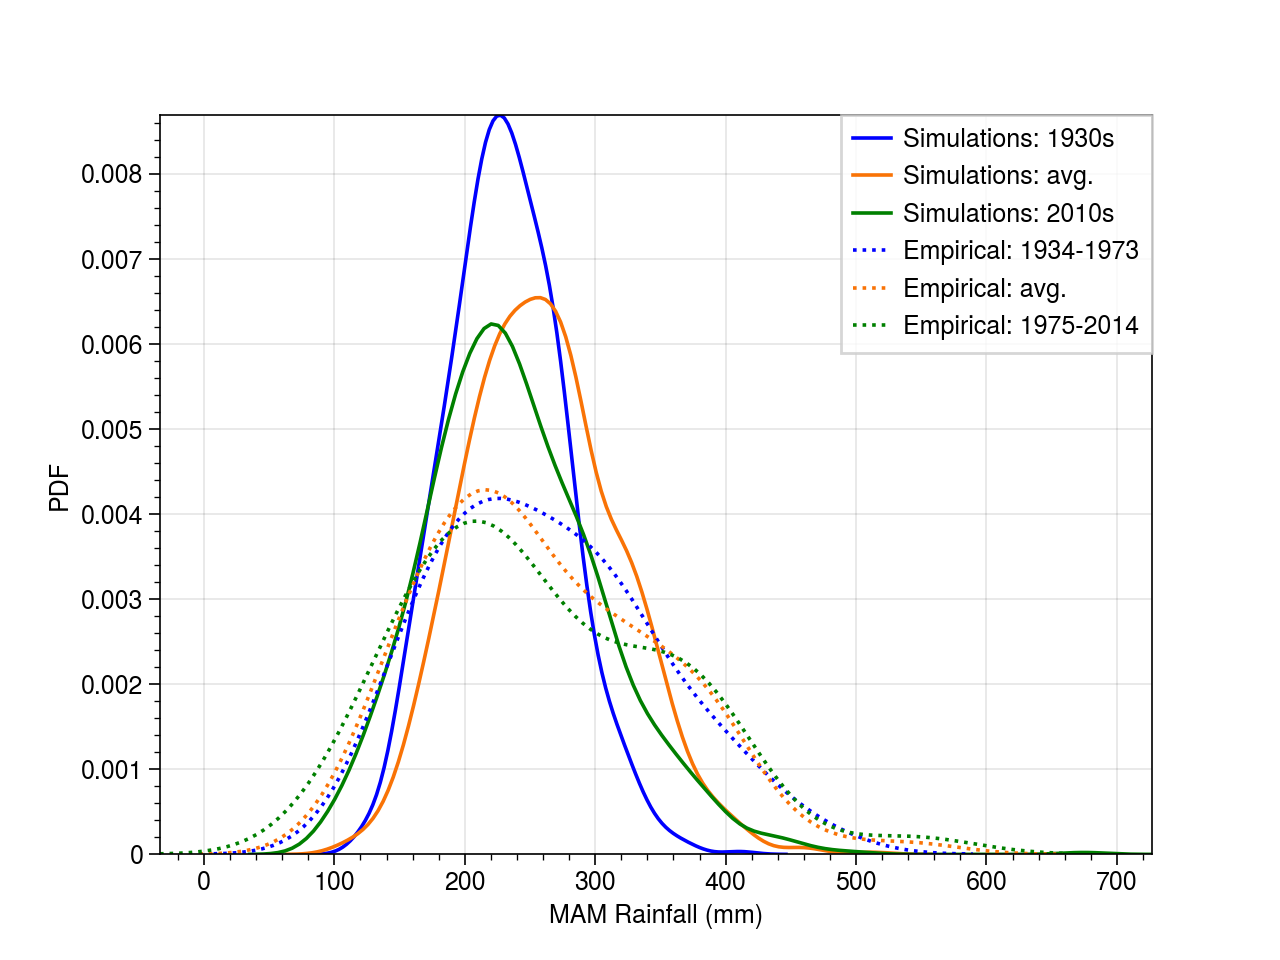

In [239]:
#rf.query('Month' == 3 | 4 | 5)
rf_mam = rf.loc[rf['Month'].isin(['3','4','5'])]
rf_mam = rf_mam.groupby(['Year'])['JACOBSON FARM'].sum().to_frame()

# Then seperate into first 40 years, last 40 years and average???
# I dont thimnk this is right but going to do it anywahs

len(rf_mam[rf_mam.index > 1974]) # 40
len(rf_mam[rf_mam.index < 1974]) # 40

# Distributions of MAM rainfall

sns.kdeplot(r0['mam_RF'], color='blue',label="Simulations: 1930s") # can change bandwith to see how tightly estimation fits the data
sns.kdeplot(r1['mam_RF'], color='orange',label="Simulations: avg.") # bw=.2
sns.kdeplot(r2['mam_RF'], color='green', label="Simulations: 2010s")

sns.kdeplot(rf_mam[rf_mam.index < 1974]['JACOBSON FARM'], color='blue',label="Empirical: 1934-1973", linestyle=":") # bw=.2
sns.kdeplot(rf_mam['JACOBSON FARM'], label="Empirical: avg.", color='orange',linestyle=":") # can change bandwith to see how tightly estimation fits the data
sns.kdeplot(rf_mam[rf_mam.index > 1974]['JACOBSON FARM'], color='green',label="Empirical: 1975-2014", linestyle=":")
plt.legend();
plt.ylabel('PDF')
plt.xlabel('MAM Rainfall (mm)')

# Table of means

table = pd.DataFrame({
                   # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
            'Source':['Simulations','Simulations','Simulations','Empirical','Empirical','Empirical'],
        'Rainfall Era':['1930s','Avg.','2010s',
                                             '1934-1973','Avg.','1975-2014'],
            'Average':[r0['mam_RF'].mean(),r1['mam_RF'].mean(),r2['mam_RF'].mean(),
                       rf_mam[rf_mam.index < 1974]['JACOBSON FARM'].mean(),rf_mam['JACOBSON FARM'].mean(),
                       rf_mam[rf_mam.index > 1974]['JACOBSON FARM'].mean()],
            'Standard Deviation':[r0['mam_RF'].std(),r1['mam_RF'].std(),r2['mam_RF'].std(),
                       rf_mam[rf_mam.index < 1974]['JACOBSON FARM'].std(),rf_mam['JACOBSON FARM'].std(),
                       rf_mam[rf_mam.index > 1974]['JACOBSON FARM'].std()],
            'No. in Sample':[len(r0['mam_RF']),len(r1['mam_RF']),len(r2['mam_RF']),
                       len(rf_mam[rf_mam.index < 1974]['JACOBSON FARM']),len(rf_mam['JACOBSON FARM']),
                       len(rf_mam[rf_mam.index > 1974]['JACOBSON FARM'])]})

table

Dekad
1     104
2     106
3     119
4      95
5     108
6     120
7     171
8     180
9     255
10    334
11    399
12    397
13    359
14    254
15    167
16    146
17    129
18    120
19    118
20    135
21    136
22    138
23    139
24    166
25    153
26    138
27    145
28    195
29    225
30    332
31    385
32    392
33    344
34    317
35    248
36    171
37    103
Name: JACOBSON FARM, dtype: int64

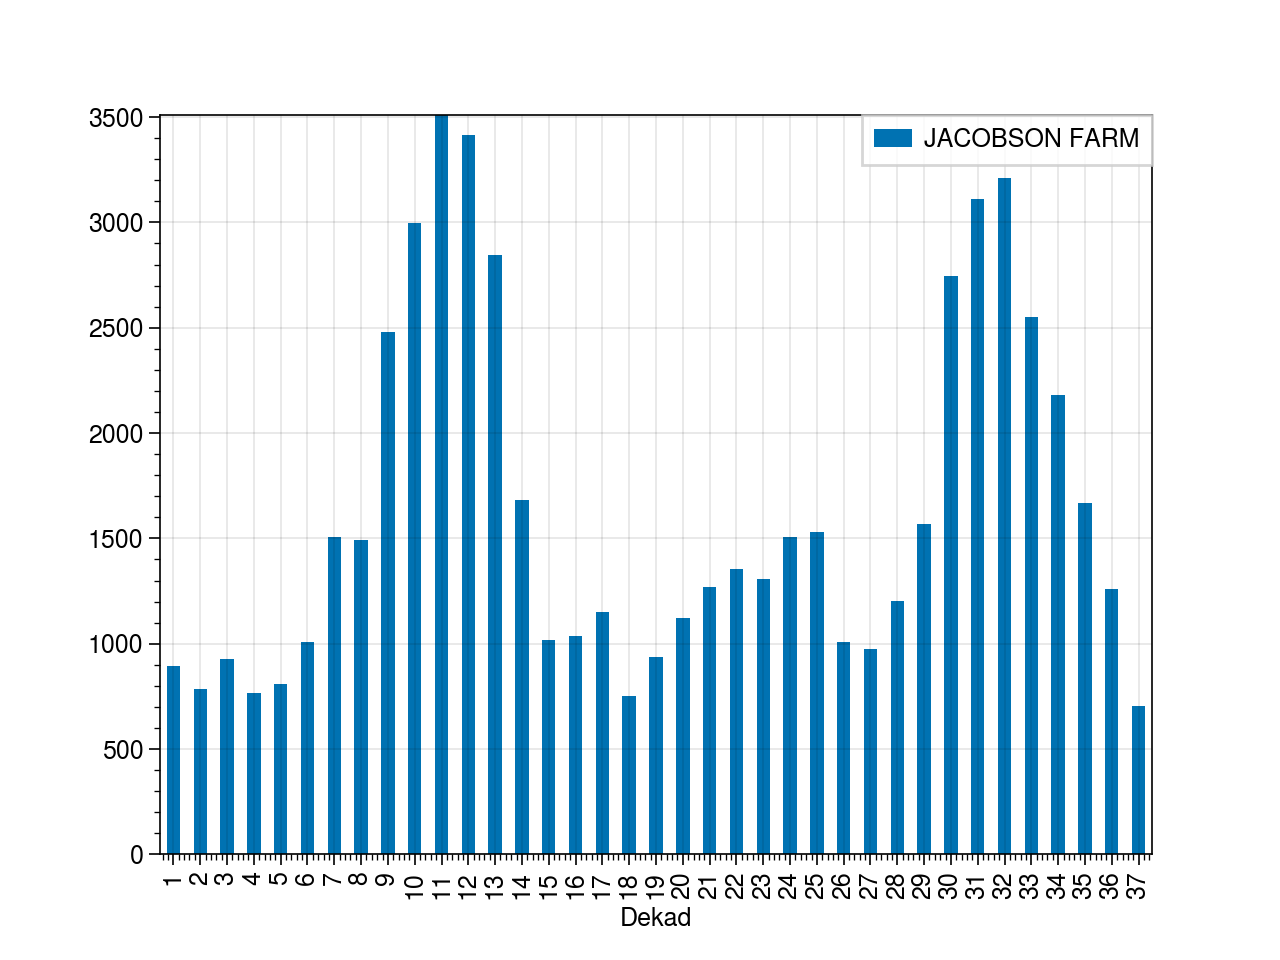

In [247]:
# what does the dekadal rainfall look like

# Maybe we need to take the average not the sum
rf_dek = rf_jf.groupby(['Dekad'])['JACOBSON FARM'].sum().to_frame()
rf_dek.plot(kind='bar')
rf_dek

sum(rf_dek['JACOBSON FARM']/80) # This is about right for an annual total

rf_dek['JACOBSON FARM']/80 # These are a little large though

rf_jf.groupby(['Dekad'])['JACOBSON FARM'].mean().to_frame() # This is the average through the whole record
# what is the average of this

# Oh because this is also counting zeros
rf_jf.groupby(['Dekad'])['JACOBSON FARM'].mean().to_frame().mean() # This seems a little low

# This is how we do it in make_climate_parameters
# alpha vals
rain_days.groupby('Dekad')['JACOBSON FARM'].mean().mean()

#lambda_values = (
rain_days.groupby('Dekad')['JACOBSON FARM'].count() / all_days.groupby('Dekad')['JACOBSON FARM'].count()

rain_days.groupby('Dekad')['JACOBSON FARM'].count()

## What I had done previosly

In [ ]:
# Import 10,000 growing seasons simulation

n_sim = 10000
no_sims = np.arange(0,n_sim)

files = glob.glob('../output/final/*.csv')
output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

# Example time series to check length
output[99]

In [ ]:
# Define variables
soil = Soil(texture=texture)
crop = Crop(soil=soil, lgp=lgp)
soil.set_nZr(crop)

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output] 
RF = [df['R'].sum() for df in output]
df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
df['RF'] = RF
print(max(df.Yield)/1000)

In [ ]:
# Reminder of the relationship we're working with: Dynamic Stress Yield Rlxn

def fig3(df=None):
    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Scatter plot of raw data
    max(df.Yield)

    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu2') #, tight=False
    axs.format(
        abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
     
    plt.scatter(df.RF, df.Yield_norm, alpha=0.4, size=2.5) # , color='black'
    plt.ylim(-.10,1.10)
    plt.xlim(100,850)
    #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
    plt.ylabel('Normalized Yield') # Yield normalized by max. yield
    plt.xlabel('Seasonal Rainfall (mm)')
    #plt.savefig('../output/6-results/dynstress.png',format='png')
    # New fit
    #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
    #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
    # confidence intervals around line?
    
fig3(df=df)

## Step 1: Bin into 50 mm increments

In [ ]:
# roughly how many groups if in 50 mm incremements?
print((max(RF) - min(RF))/50)

result = pd.DataFrame(RF)
result['RF_bins'] = pd.cut(RF,12)
#result['RF_bins'] = pd.cut(RF,12, labels=labels)

result.RF_bins.value_counts()

## Step 2. Calculate cv of those rainfall bins

In [ ]:
cv = result.groupby(['RF_bins'])[0].std() / result.groupby(['RF_bins'])[0].mean(); print(cv)
cv_dict = cv.to_dict()

## Step 3. Plot crop failure as a function of cv

In [ ]:
# Map cv onto dataframe
df['cv'] = df['RF'].map(cv_dict)

# Take only instances where crop failed
df_fail = df.loc[df['Yield'] == 0]

# For a given cv, get percentage of times the crop failed
df

In [ ]:
# Plot crop failure as a function of CV
plt.scatter(df.cv, df.Yield)
plt.ylabel('Yield') # Yield normalized by max. yield
plt.xlabel('CV')

## Deleted stuff I don't need anymore



In [ ]:
# Make the three figs for rainfall-yield relationship


# def fig3(df=None):
#     # We'll be using these variables a lot
#     x = df.RF
#     y = df.Yield

#     # Scatter plot of raw data
#     max(df.Yield)

#     df['Yield_norm'] = df.Yield/max(df.Yield)

#     f, axs = plot.subplots(journal='agu2') #, tight=False
#     axs.format(
#         abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
     
#     plt.scatter(df.RF, df.Yield_norm, alpha=0.4, size=2.5) # , color='black'
#     plt.ylim(-.10,1.10)
#     plt.xlim(100,850)
#     #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
#     plt.ylabel('Normalized Yield') # Yield normalized by max. yield
#     plt.xlabel('Seasonal Rainfall (mm)')
#     #plt.savefig('../output/6-results/dynstress.png',format='png')
#     # New fit
#     #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
#     #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
#     # confidence intervals around line?
    
# fig3(df=r0)

In [ ]:
# def fig3(df1=None, df2=None, df3=None):
#     df1['Yield_norm'] = df1.Yield/max(df1.Yield)
#     df2['Yield_norm'] = df2.Yield/max(df2.Yield)
#     df3['Yield_norm'] = df3.Yield/max(df3.Yield)

#     f, axs = plot.subplots(nrows=1, ncols=3,journal='agu2') #, tight=False
#     axs.format(
#         abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship')
     
#     axs[0].scatter(df1.RF, df1.Yield_norm, alpha=0.4, size=2.5) # , color='black'
#     axs[1].scatter(df2.RF, df2.Yield_norm, alpha=0.4, size=2.5, color='red')
#     axs[2].scatter(df3.RF, df3.Yield_norm, alpha=0.4, size=2.5, color='purple')
#     #plt.ylim(-.10,1.10)
#     #plt.xlim(100,850)
#     #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
#     #plt.ylabel('Normalized Yield') # Yield normalized by max. yield
#     #plt.xlabel('Seasonal Rainfall (mm)')
#     #plt.savefig('../output/6-results/dynstress.png',format='png')
#     # New fit
#     #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
#     #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
#     # confidence intervals around line?
    
# fig3(df1=r0, df2=r1, df3=r2)

In [ ]:
# def fig3(df1=None, df2=None, df3=None):
#     df1['Yield_norm'] = df1.Yield/max(df1.Yield)
#     df2['Yield_norm'] = df2.Yield/max(df2.Yield)
#     df3['Yield_norm'] = df3.Yield/max(df3.Yield)

#     f, axs = plot.subplots(ncols=3,nrows=1,figsize=(8,3), sharey=True, sharex=True) #, tight=False
#     axs.format(
#         abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship')
     
#     #axs[0].scatter(df1.RF, df1.Yield_norm, alpha=0.4, size=2.5) # , color='black'
#     #axs[1].scatter(df2.RF, df2.Yield_norm, alpha=0.4, size=2.5, color='red')
#     #axs[2].scatter(df3.RF, df3.Yield_norm, alpha=0.4, size=2.5, color='purple')
#     sns.kdeplot(df1.RF, df1.Yield/1000, xlim=(0,700),ylim=(-0.5,4.5),alpha=0.5,kind='kde',cmap="orange1", 
#                   shade=True, shade_lowest=False, cbar=True) # ,ax=axs[0]
#     #plt.ylim(-.10,1.10)
#     #plt.xlim(100,850)
#     #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
#     #plt.ylabel('Normalized Yield') # Yield normalized by max. yield
#     #plt.xlabel('Seasonal Rainfall (mm)')
#     #plt.savefig('../output/6-results/dynstress.png',format='png')
#     # New fit
#     #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
#     #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
#     # confidence intervals around line?
    
# fig3(df1=r0, df2=r1, df3=r2)

In [ ]:
# Reminder of the relationship we're working with: Dynamic Stress Yield Rlxn

# def fig3(df=None):
#     # We'll be using these variables a lot
#     x = df.RF
#     y = df.Yield

#     # Scatter plot of raw data
#     max(df.Yield)

#     df['Yield_norm'] = df.Yield/max(df.Yield)

#     f, axs = plot.subplots(journal='agu2') #, tight=False
#     axs.format(
#         abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
     
#     plt.scatter(df.RF, df.Yield_norm, alpha=0.4, size=2.5) # , color='black'
#     plt.ylim(-.10,1.10)
#     plt.xlim(100,850)
#     #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
#     plt.ylabel('Normalized Yield') # Yield normalized by max. yield
#     plt.xlabel('Seasonal Rainfall (mm)')
#     #plt.savefig('../output/6-results/dynstress.png',format='png')
#     # New fit
#     #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
#     #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
#     # confidence intervals around line?
    
# fig3(df=result)

In [ ]:
# Double check that the figure looks good 

# def figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
#     """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

#     Usage: figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
#         Takes all the outputs from the previous function

#     """
#     # Step 2: Make figures
#     # Part 6. Decide whether using white (publication) or black background (presentation): 
#     # for white background
#     col='k'
    
#     # for black backgroumd
#     #col='white'
    
#     # Since we're using the reimported outputs, we can set start and end to 0 and 180
#     #start = 0
#     #end = 180
#     #burn_in = 1
#     # If we were using the raw output we'd need to have the previous start and end values
#     # That's what we're doing!
    
#     start = 60
#     end = 240
    
#     f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
#     axs.format(
#         abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
#     )
#     axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

#     # TOP FIGURE
#     # Do some shenanigans to select a simulation that dips below wilting point
#     s_min = []
#     no_sims = np.arange(0,n_sim)
    
#     for i in no_sims:
#         #print(output[i][start:end]['s'].min())
#         _s_min = output[i][start:end]['s'].min()
#         s_min.append(_s_min)
#     result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

#     # which simulation has the smallest s value?
#     lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
#     print(lowest)
#     lowest=989
#     # Figure 1a: Rainfall from one simulation
#     rf = output[lowest][start:end]['R']
#     stress = output[lowest][start:end]['stress']
    
#     # Adjust index to account for the fact that python is zero-indexed
#     rf.index = rf.index+1 # change index so that we can see day of season
#     stress.index = stress.index+1
    
#     axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
#     axs[0,0].format(ylabel='Daily rainfall / mm')
#     #axs[0,0].format(xlabel='Day of season')
#     axs[0,0].format(xlabel='Day of year')
#     #axs[0,0].format(xlim=(60, 240))
#     # Figure 1c: stress from one simulation
#     axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
#     axs[0,2].format(ylabel='Stress')
#     #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
#     #axs[0,2].format(xlabel='Day of season')
#     axs[0,2].format(xlabel='Day of year')
        
#     # Figure 1b: Soil moisture from one simulation
#     # convert saturation to volumetric water content:
#     # relative saturation*porosity
#     # we have the function theta already but I'm not sure that we call on that.
#     vwc = output[lowest][start:end]['s']*Soil(texture).n
    
#     _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
#     _sw = crop.sw*Soil(texture).n
    
#     # LEGEND
#     hs = []
#     cycle = ['-','--']
#     var = [_sstar, _sw]
#     LABEL = ['Stress point (s*)','Wilting point (sw)']
    
#     for item, cycle, LABEL in zip(var, cycle, LABEL):
#         h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
#         hs.append(h)
    
#     f.legend(hs, loc='right', ncols=1, frame=True)
    
#     # Adjust index to account for the fact that python is zero-indexed
#     vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
#     axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
#     axs[0,1].format(ylabel='Volumetric water content / mm')
#     #axs[0,1].format(xlabel='Day of season')
#     axs[0,1].format(xlabel='Day of year')
#     #axs[0,1].format(xlim=(60, 240))
#     #plt.savefig('../output/6-results/fig1.png',format='png')
    
#     # Figure 2
#     f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
#     axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
#     # Figure a: Soil moisture distribution - converted
#     ax = axs[0,0]
#     avg_s = np.array(avg_s)*Soil(texture).n
#     sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
#     #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
#     ax.format(ylabel=r'p($\overline{vwc}$)')
#     ax.format(xlabel='Volumetric Water Content (mm)')
    
#     # Figure c: Stress distribution
#     ax = axs[1,0]
#     avg_stress = [df[start:end]['stress'].mean() for df in output]
#     sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
#     #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
#     ax.format(ylabel=r'p($\overline{stress}$)')
#     ax.format(xlabel='Stress')
    
#     # Figure b: Soil moisture time series - need to convert this one
#     avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
#     avg_daily = avg_daily*Soil(texture).n; avg_daily
#     avg_daily_t = avg_daily.T; avg_daily_t
#     daily_mean = avg_daily.mean(axis=1); daily_mean
#     daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
#     daily_mean
#     #data = np.array(daily_mean)
#     axs[0,1].plot(daily_mean, color=col, lw=2)

#     x = np.arange(1, len(daily_mean)+1, 1)
#     # use this for raw output
#     #x = np.arange(60, 240, 1)

#     # set custom x axis
#     #axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))
    
#     quant = avg_daily_t.quantile([.1, .9])
#     quant = quant.T
#     axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
#     axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
#     #axs[0,1].format(xlabel='Day of season')
#     axs[0,1].format(xlabel='Day of year')
#     axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
#     # Figure f: stress time series
#     stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
#     stress_t = stress.T
#     daily_mean = stress.mean(axis=1)
#     daily_mean.index = daily_mean.index + 1 
#     axs[1,1].plot(daily_mean, color=col, lw=2)

#     #x = np.arange(1, len(daily_mean)+1, 1) 
#     quant = stress_t.quantile([.1, .9])
#     quant = quant.T
#     axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
#     axs[1,1].format(ylim=(-0.05, 1))
#     plt.ylabel('Stress')
#     axs[1,1].format(ylabel='Stress')
#     #axs[1,1].format(xlabel='Day of season')
#     axs[1,1].format(xlabel='Day of year')
#     ax.xaxis.label.set_color(col)
#     axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
#     #axs.format(
#     # set custom x axis
#     #axs[1,1].format(xlim=(60, 240)) #
#     #rowlabels=['Volumetric Water Content', 'Stress'],
#     collabels=['PDF', 'Time Series']
    
#     #plt.savefig('../output/6-results/fig2.png',format='png')
#     print('s star',_sstar,'sw',_sw)

# figure1b(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)